# Intra-frame main analysis

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
# External packages
import os
import jupyter_slack
import datetime

# Internal modules
from usnm2p.logger import logger
from usnm2p.constants import *
from usnm2p.utils import *
from usnm2p.fileops import *
from usnm2p.postpro import *
from usnm2p.plotters import *
from usnm2p.batchutils import *
from usnm2p.indexers import FrameIndexer

# Root directory for output figures
figsdir = get_data_root(kind=DataRoot.FIG)  
logger.info(f'output figures directory: "{figsdir}"')

# Get time stamp from notebook completion
tstamp_start = datetime.datetime.now()

# Figures dictionary
figs = {}

 2025/07/09 15:49:18: output figures directory: "/Users/tlemaire/Documents/data/usnm/figs"


### Input datasets and main processing parameters

In [3]:
analysis_type = 'main'  # Analysis type
mouseline = 'pv'
layer = None  # cortical layer
slack_notify = False

### Derived parameters

In [4]:
group_key, group_refval = {  # Grouping variable and reference value for the analysis
    'main': (Label.ISPTA, 0.),
    'offset': (Label.OFFSET, 2.0),
}[analysis_type]
refcolor = Palette.LINE[mouseline] # Reference color for the plot

### Load and organize data

In [16]:
# Get data directory
dataroot = get_data_root(kind=DataRoot.ROWAVG)
datadir = os.path.join(dataroot, analysis_type, mouseline)
logger.info(f'input data directory: {datadir}')

# List data files
datafiles = [f for f in os.listdir(datadir) if f.endswith('.h5')]

# For each input file
trialagg_dFF, info_table = {}, {}
for fname in datafiles:
    # Parse dataset ID from file name
    dataset_ID = os.path.splitext(fname)[0]
    
    # Load dFF data and info table
    dFF, table = load_rowavg_dataset(os.path.join(datadir, fname))
    
    # If no baseline data, skip this dataset
    if group_key == Label.ISPTA and not any(table[Label.P] == 0.):
        logger.warning(f'no data for P = 0 in {dataset_ID} -> skipping')
        continue
    
    # Restrict data to non-duplicated runs
    codefunc = get_param_code if group_key == Label.ISPTA else get_offset_code
    iruns = codefunc(table).drop_duplicates(keep='first').index.values
    table = table.loc[iruns]
    # mux_slice = get_mux_slice(dFF.index)
    # mux_slice[0] = tuple(iruns)
    # print(mux_slice)
    print(dFF)
    print(dFF.index.unique(level=Label.RUN))
    dFF = dFF.loc[iruns]# pd.IndexSlice[iruns, :, :, :]]
    print(dFF)
    # Average dFF data across trials, and add to dictionary
    logger.info('computing trial-average dFF profiles')
    info_table[dataset_ID] = table
    trialagg_dFF[dataset_ID] = dFF.groupby([Label.RUN, Label.FRAME, Label.ROW]).mean()

# Assemble trial-average dFF profiles into multi-indexed pandas Series
logger.info(f'assembling {len(trialagg_dFF)} datasets into single multi-indexed series')
trialagg_dFF = pd.concat(trialagg_dFF, axis=0, names=[Label.DATASET])

# Assemble info table into single DataFrame
info_table = pd.concat(info_table, axis=0, names=[Label.DATASET])

# Extract constant parameters from info table
PRF = get_singleton(info_table, Label.PRF)
dur = get_singleton(info_table, Label.DUR)
fps = get_singleton(info_table, Label.FPS)
lpf = get_singleton(info_table, Label.LPF)
nframes_per_trial = get_singleton(info_table, Label.NPERTRIAL)
npulses = int(dur * PRF)

# Add relevant columns to info table
if group_key == Label.ISPTA:
    # For main analysis, add ISPTA and ISPPA columns
    info_table = add_intensity_to_table(info_table, precision=2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.P, Label.DC, Label.ISPPA, group_key]

elif group_key == Label.OFFSET:
    # For offset analysis, add transducer XY coordinates and offsets
    logger.info('parsing transducer XY offset coordinates...')
    offsets_2d = get_offset_complex(info_table)
    info_table['xoff (mm)'] = offsets_2d.apply(np.real)
    info_table['yoff (mm)'] = offsets_2d.apply(np.imag)
    xykeys = ['xoff (mm)', 'yoff (mm)']
    info_table[Label.OFFSET] = np.linalg.norm(info_table[xykeys], axis=1).round(2)

    # Determine keys to add to trialagg_dFF
    exp_keys = [Label.SUFFIX, *xykeys, group_key]

# Extract stimulus onset time from info table, and construct FrameIndexer
tref = get_stim_onset_time(mouseline)
fidx = FrameIndexer.from_time(tref, TPRE, TPOST, 1 / fps, npertrial=nframes_per_trial).resample(lpf)

# Subtract pre-stimulus baseline levels for each dataset and run
logger.info('subtracting pre-stimulus baseline levels')
gby = [Label.DATASET, Label.RUN]
def subtract_baseline(y):
    y0 = y.droplevel(gby).loc[:fidx.iref].median()
    return y - y0
trialagg_dFF = trialagg_dFF.groupby([Label.DATASET, Label.RUN]).transform(subtract_baseline)

# Add relevant columns to trialagg_dFF
trialagg_dFF = free_expand_and_add(info_table[exp_keys], trialagg_dFF.to_frame())

# Remove data for DC = 1%, if present
if Label.DC in trialagg_dFF.columns:
    logger.info('removing data for DC = 1%')
    trialagg_dFF = trialagg_dFF[trialagg_dFF[Label.DC] != 1.0]

# Add time vector to trial-aggregated dFF
add_time_to_table(trialagg_dFF, fidx=fidx, fps=fps * lpf)

# Create a mapping from grouping variable to DC
col_DC_map = info_table.groupby(group_key).first()[Label.DC]
if group_key == Label.ISPTA:  # Set DC = 0 for ISPTA = 0
    col_DC_map.loc[0.] = 0. 

# # Add frame and row index column to trialagg_dFF
# logger.info('adding frame and row index columns')
# trialagg_dFF[Label.ROW] = trialagg_dFF.index.get_level_values(Label.FRAMEROW) % lpf
# trialagg_dFF[Label.FRAME] = trialagg_dFF.index.get_level_values(Label.FRAMEROW) // lpf

trialagg_dFF

 2025/07/09 16:08:06: input data directory: /Users/tlemaire/Documents/data/usnm/rowavg/main/pv
 2025/07/09 16:08:06: loading row-average dFF data from 20190606_mouse2_region2.h5
 2025/07/09 16:08:06: loading experiment info table...
run  trial  frame  row
0    0      0      0     -1.000000
                   1     -1.000000
                   2     -1.000000
                   3     -1.000000
                   4     -1.000000
                            ...   
2    15     99     251    0.024538
                   252    0.033807
                   253    0.025313
                   254    0.036484
                   255    0.022258
Name: ΔF/F0, Length: 1228800, dtype: float64
Index([0, 1, 2], dtype='int64', name='run')


KeyError: '[3 4 5 6 7 8 9] not in index'

### Define plot parameters

In [6]:
# Restrict time bounds for plotting 
tbounds = {
    'default': (-1, 5),  # Default time bounds
    'zoomed': (-0.1, 0.3)  # Time bounds around stimulus
}

# Common plot parameters
pltkwargs = {
    'col': group_key,
    'col_DC_mapper': col_DC_map,
    'stimdur': dur,
    'stimPRF': PRF,
    'fps': fps,
    'stimdelay': STIM_TRIG_DELAY,
}

### Plot trial-aggregated dFF vs grouping variable, across datasets (default and zoom-in around stimulus)

 2025/07/09 14:17:53: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/09 14:18:14: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


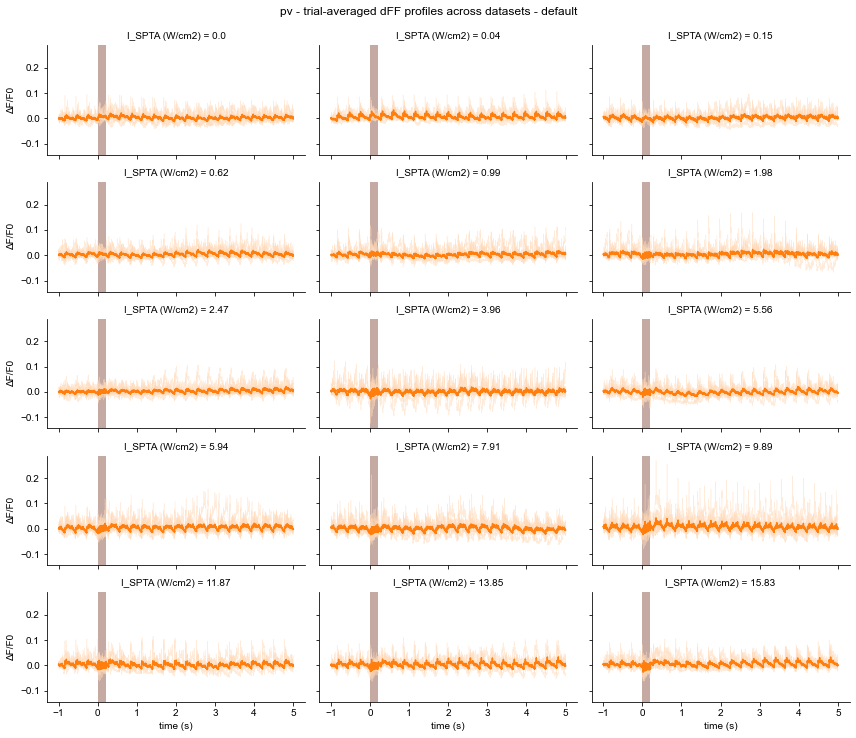

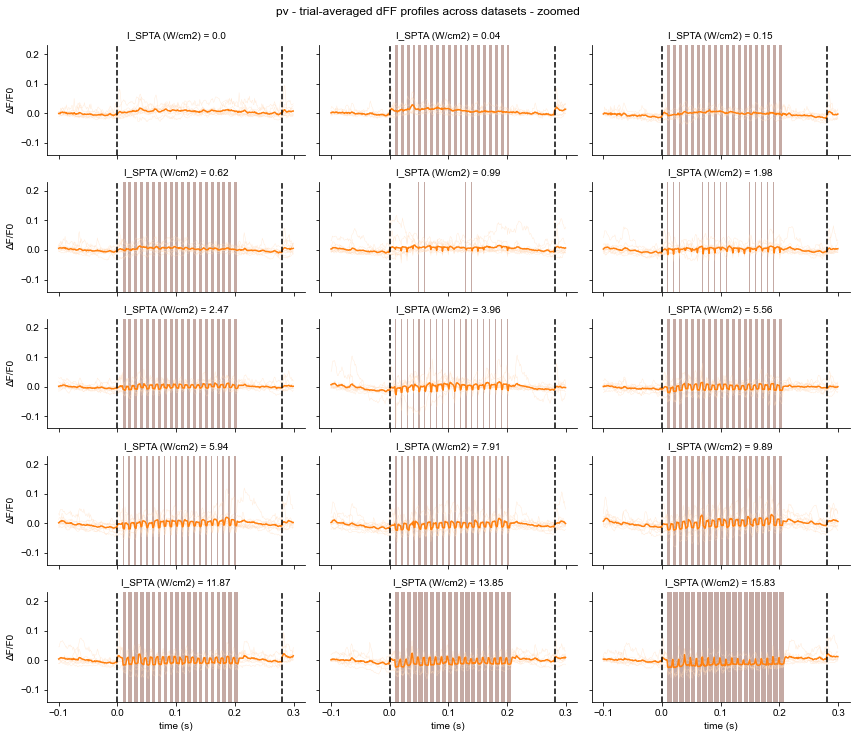

In [7]:
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles across datasets - {k}'
    figs[title] = plot_rowagg_profiles(
        trialagg_dFF.copy(), tbounds=v, units=Label.DATASET, color=refcolor, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

### Show only cross-dataset average

 2025/07/09 14:18:20: computing cross-dataset aggregates
 2025/07/09 14:18:21: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/09 14:18:22: computing cross-dataset aggregates
 2025/07/09 14:18:22: plotting ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


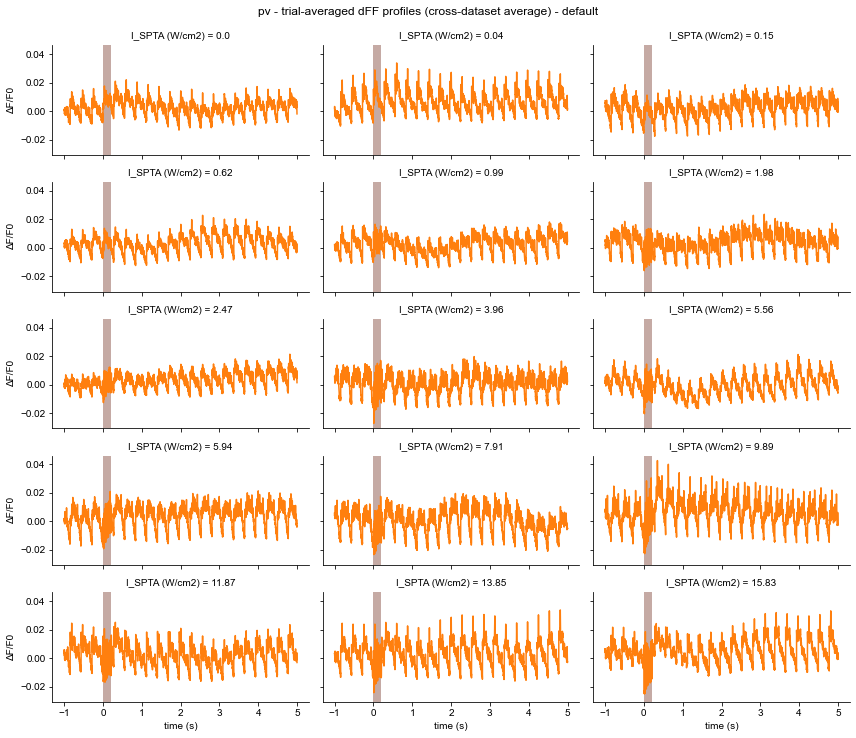

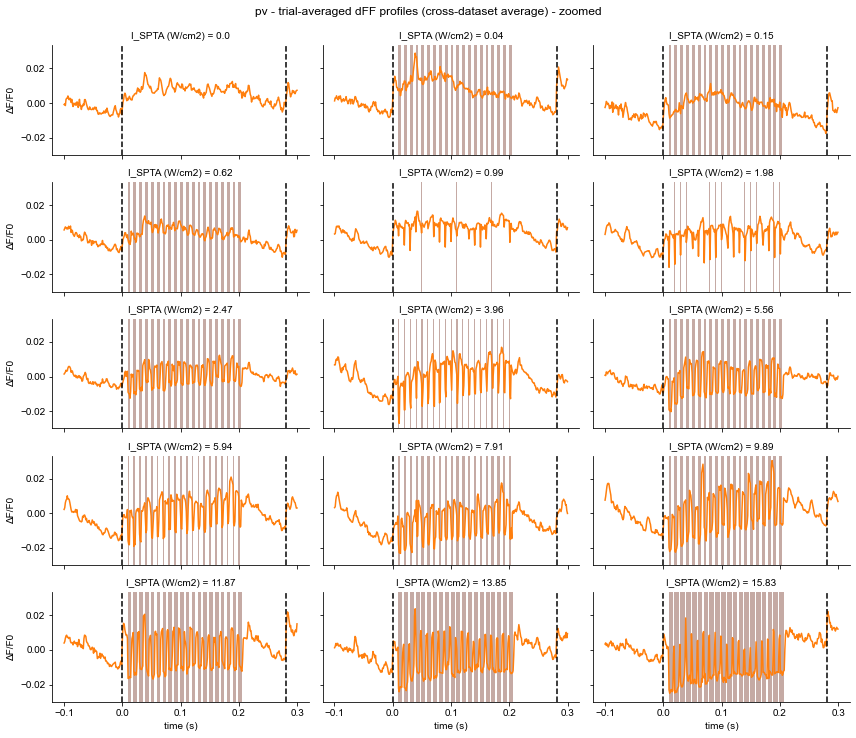

In [8]:
# Define function to aggregate across datasets
def aggregate_across_datasets(data):
    '''
    Aggregate across datasets by averaging dFF columns and 
    keeping first values for other columns.
    '''
    logger.info('computing cross-dataset aggregates')
    agg_funcs = {k: 'mean' if Label.DFF in k else 'first' for k in data.columns}
    return data.groupby([group_key, Label.FRAMEROW]).agg(agg_funcs).drop(group_key, axis=1)


# Plot cross-dataset average trial-averaged dFF
for k, v in tbounds.items():
    title = f'{mouseline} - trial-averaged dFF profiles (cross-dataset average) - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF), tbounds=v, color=refcolor, **pltkwargs)
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = Label.DFF

### Fit and subtract physiological response trend

 2025/07/09 14:18:26: interpolating dFF values to extract slow physiological response trend
 2025/07/09 14:18:29: subtracting interpolated response trend from original profile
 2025/07/09 14:18:29: computing cross-dataset aggregates
 2025/07/09 14:18:29: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/09 14:18:32: computing cross-dataset aggregates
 2025/07/09 14:18:33: plotting ['ΔF/F0', 'ΔF/F0 response trend', 'response corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


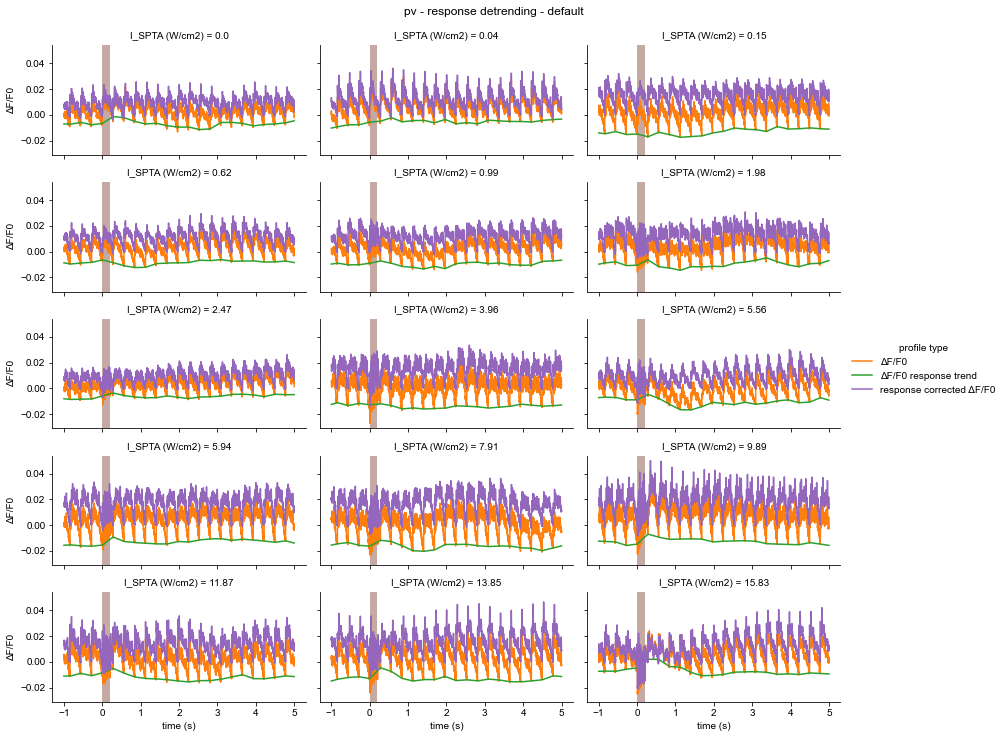

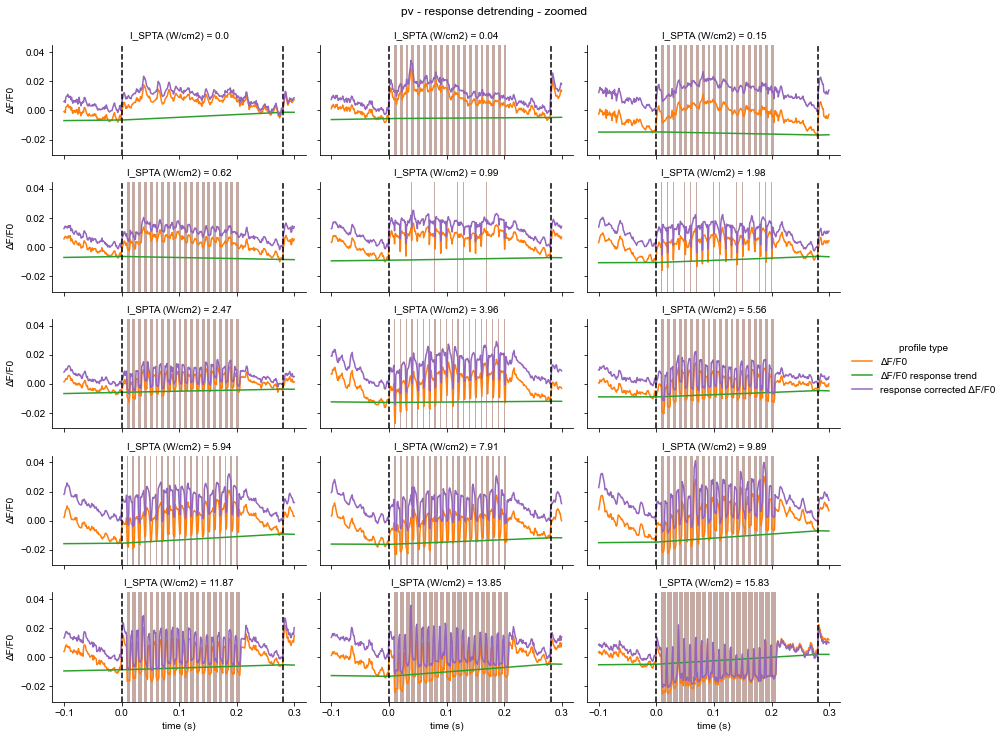

In [9]:
# Interpolate dFF values between the last row of each frame to extract "physiological response trend"
logger.info('interpolating dFF values to extract slow physiological response trend')
resp_ykey = f'{input_ykey} response trend'
trialagg_dFF[resp_ykey] = trialagg_dFF[input_ykey].copy()
trialagg_dFF.loc[trialagg_dFF[Label.ROW] != (lpf - 1), resp_ykey] = np.nan
trialagg_dFF.loc[pd.IndexSlice[:, :, 0], resp_ykey] = trialagg_dFF.loc[pd.IndexSlice[:, :, 0], input_ykey]
gby = [Label.DATASET, Label.RUN]
trialagg_dFF[resp_ykey] = (
    trialagg_dFF
    .groupby(gby)
    [resp_ykey]
    .apply(lambda x: x.droplevel(gby).interpolate(method='linear'))
)

# Subtract interpolated response trend from original profile
logger.info('subtracting interpolated response trend from original profile')
resp_corrected_ykey = f'response corrected {input_ykey}'
trialagg_dFF[resp_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[resp_ykey]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - response detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, resp_ykey, resp_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = resp_corrected_ykey

### Predict and subtract expected "scanning artifact"

 2025/07/09 14:18:39: computing average intra-frame variation profile (scanning artifact) from 3 preceding frames
 2025/07/09 14:18:39: averaging across cycles to get predictive "scanning artifact" profile
 2025/07/09 14:18:39: expanding "expected" scanning artifact profile along trial length
 2025/07/09 14:18:40: subtracting expected scanning artifact profile along trial length
 2025/07/09 14:18:41: computing cross-dataset aggregates
 2025/07/09 14:18:41: plotting ['response corrected ΔF/F0', 'expected ΔF/F0 scanning artifact', 'scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/09 14:18:46: computing cross-dataset aggregates
 2025/07/09 14:18:46: plotting ['response corrected ΔF/F0', 'expected ΔF/F0 scanning artifact', 'scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


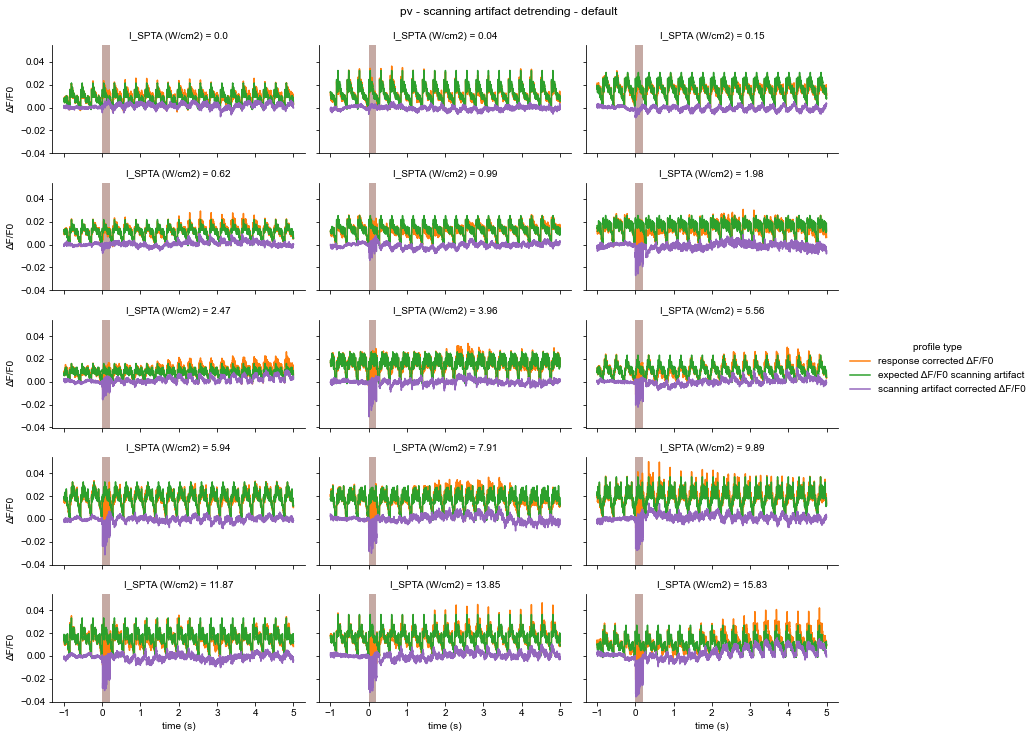

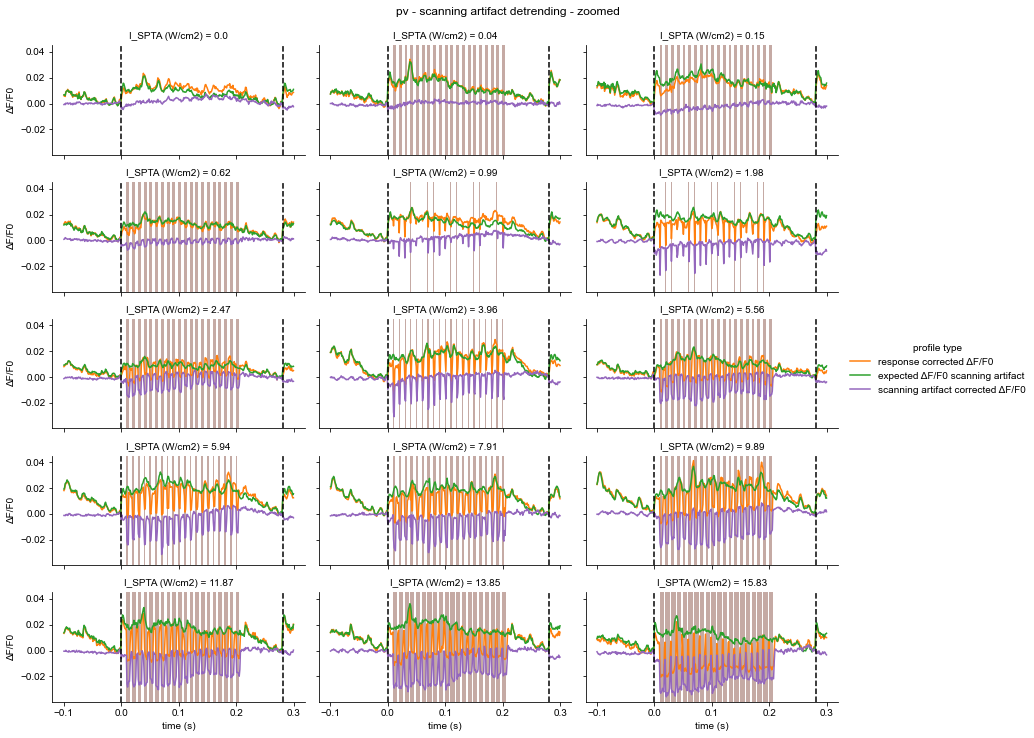

In [10]:
# Compute average intra-frame variation (scanning artifact) profile from 3 preceding frames
npre = 3
logger.info(f'computing average intra-frame variation profile (scanning artifact) from {npre} preceding frames')
preceding_tbounds = np.array([-3 / fps, 0])
preceding_ibounds = np.round(preceding_tbounds * fps * lpf).astype(int) + fidx.iref
preceding_ibounds[-1] -= 1

# Average across cycles
logger.info('averaging across cycles to get predictive "scanning artifact" profile')
ypreavg = (trialagg_dFF
    .loc[pd.IndexSlice[:, :, preceding_ibounds[0]:preceding_ibounds[-1]], [input_ykey, Label.ROW]]
    .groupby([Label.DATASET, Label.RUN, Label.ROW])
    [input_ykey]
    .mean()
)

# Tile average profile along trial length to yield "expected" scanning artifact profile
logger.info('expanding "expected" scanning artifact profile along trial length')
scanning_artifact_pred_key = f'expected {Label.DFF} scanning artifact'
trialagg_dFF[scanning_artifact_pred_key] = (ypreavg
    .groupby([Label.DATASET, Label.RUN])
    .apply(lambda x: pd.Series(
        np.tile(x.values, nframes_per_trial),
        index=pd.RangeIndex(0, x.size * nframes_per_trial, name=Label.FRAMEROW)))
)

# Subtract expected scanning artifact profile along trial length
logger.info('subtracting expected scanning artifact profile along trial length')
scanning_artifact_corrected_ykey = f'scanning artifact corrected {Label.DFF}'
trialagg_dFF[scanning_artifact_corrected_ykey] = trialagg_dFF[input_ykey] - trialagg_dFF[scanning_artifact_pred_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - scanning artifact detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, scanning_artifact_pred_key, scanning_artifact_corrected_ykey],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = scanning_artifact_corrected_ykey

### Fit and remove remaining LF baseline for each individual frame

 2025/07/09 14:18:53: applying frame-by-frame rolling filter to extract remaining intra-frame LF baseline
 2025/07/09 14:19:00: subtracting frame-by-frame baseline fit from baseline corrected profile
 2025/07/09 14:19:00: computing cross-dataset aggregates
 2025/07/09 14:19:01: plotting ['scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline fit scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -1 and 5 s
 2025/07/09 14:19:04: computing cross-dataset aggregates
 2025/07/09 14:19:04: plotting ['scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline fit scanning artifact corrected ΔF/F0', 'frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0'] time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


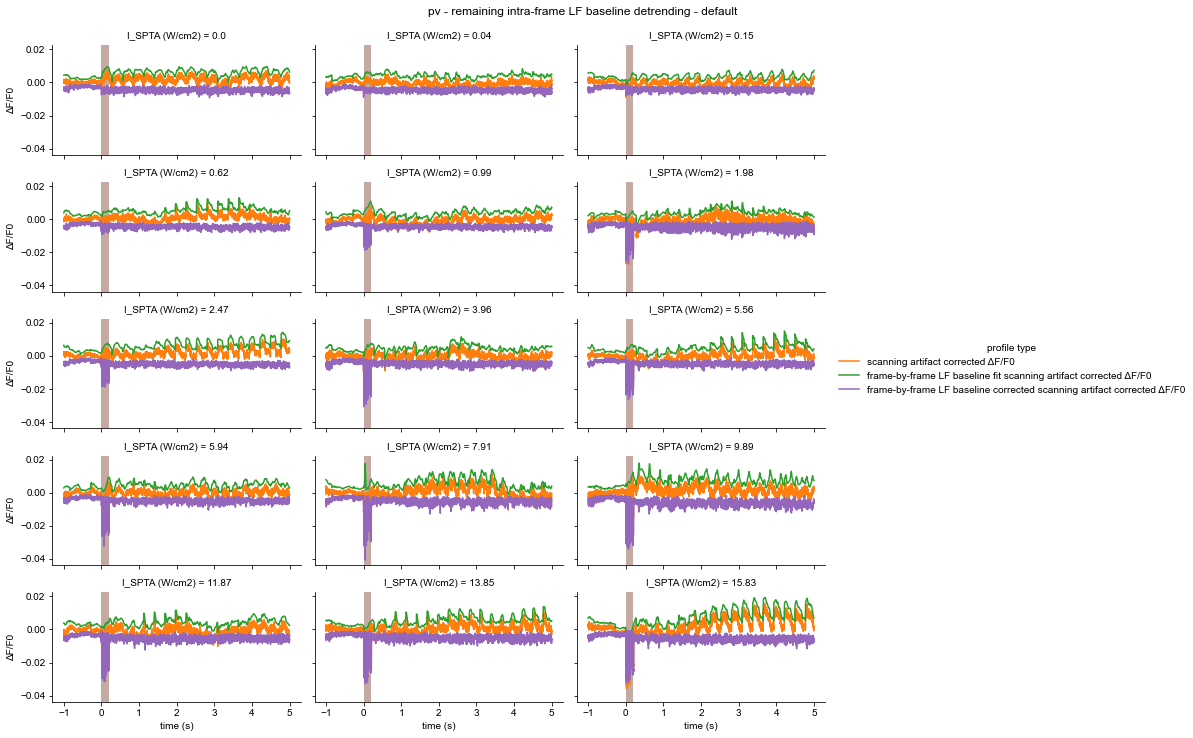

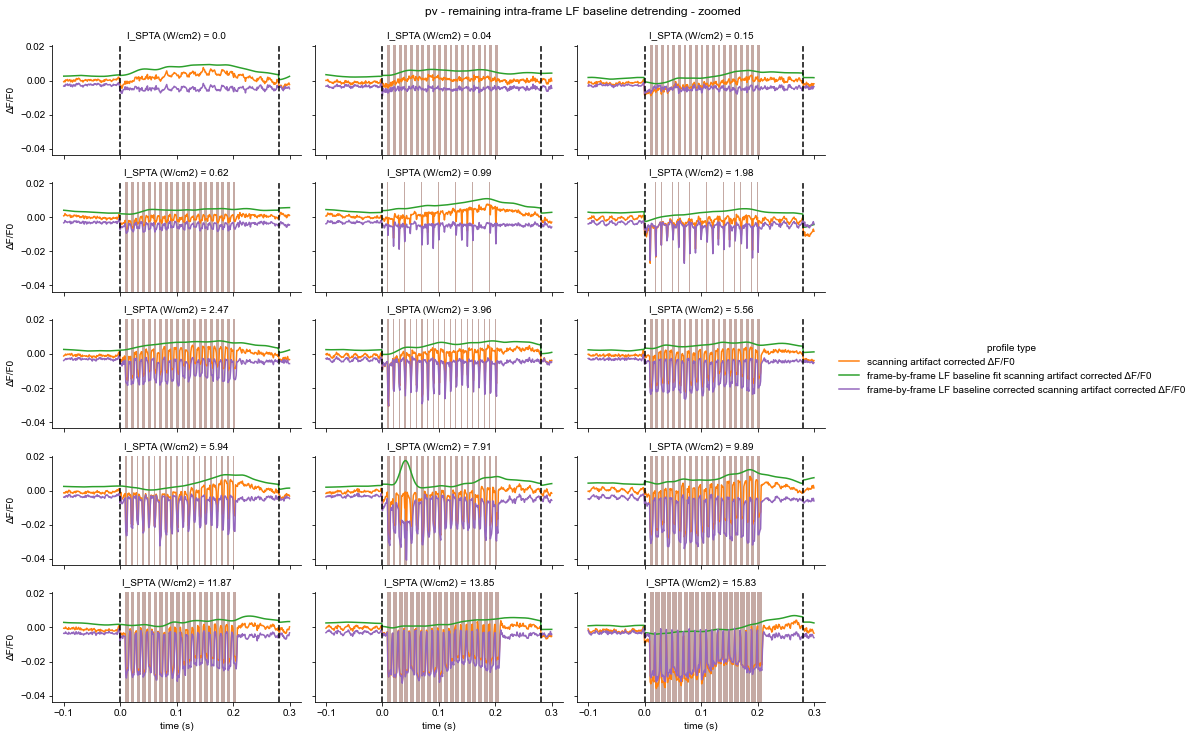

In [11]:
# Apply frame-by-frame rolling filter to extract baseline
logger.info('applying frame-by-frame rolling filter to extract remaining intra-frame LF baseline')
bfit_key = f'frame-by-frame LF baseline fit {input_ykey}'
wt = 15e-3  # Rolling window size (in s)
w = int(np.round(wt * fps * lpf))  # Rolling window size (in frames)
if w % 2 == 0:  # Ensure odd window size
    w += 1
def bfunc(y):
    return gaussian_filter1d(quantile_filter(y, w, 1), w // 2)
trialagg_dFF[bfit_key] = (trialagg_dFF
    .groupby([Label.DATASET, Label.RUN, Label.FRAME])
    [input_ykey]
    .transform(lambda y: gaussian_filter1d(quantile_filter(y.values, w, 1), w // 2))
    .values
)

# Subtract frame-by-frame baseline fit from baseline corrected profile
logger.info('subtracting frame-by-frame baseline fit from baseline corrected profile')
bcorr_key = f'frame-by-frame LF baseline corrected {input_ykey}'
trialagg_dFF[bcorr_key] = trialagg_dFF[input_ykey] - trialagg_dFF[bfit_key]

# Plot 
for k, v in tbounds.items():
    title = f'{mouseline} - remaining intra-frame LF baseline detrending - {k}'
    figs[title] = plot_rowagg_profiles(
        aggregate_across_datasets(trialagg_dFF),
        ykey=[input_ykey, bfit_key, bcorr_key],
        color=[refcolor, 'C2', 'C4'],
        tbounds=v, 
        errorbar=None,
        **pltkwargs
    )
    figs[title].suptitle(title, y=1.02)

# Determine input key for next processing stage
input_ykey = bcorr_key

### Plot final corrected profiles around stimulus window

 2025/07/09 14:19:11: computing cross-dataset aggregates
 2025/07/09 14:19:12: plotting frame-by-frame LF baseline corrected scanning artifact corrected ΔF/F0 time-varying profile per I_SPTA (W/cm2) between -0.1 and 0.3 s


Text(0.5, 1.02, 'pv - final corrected dFF')

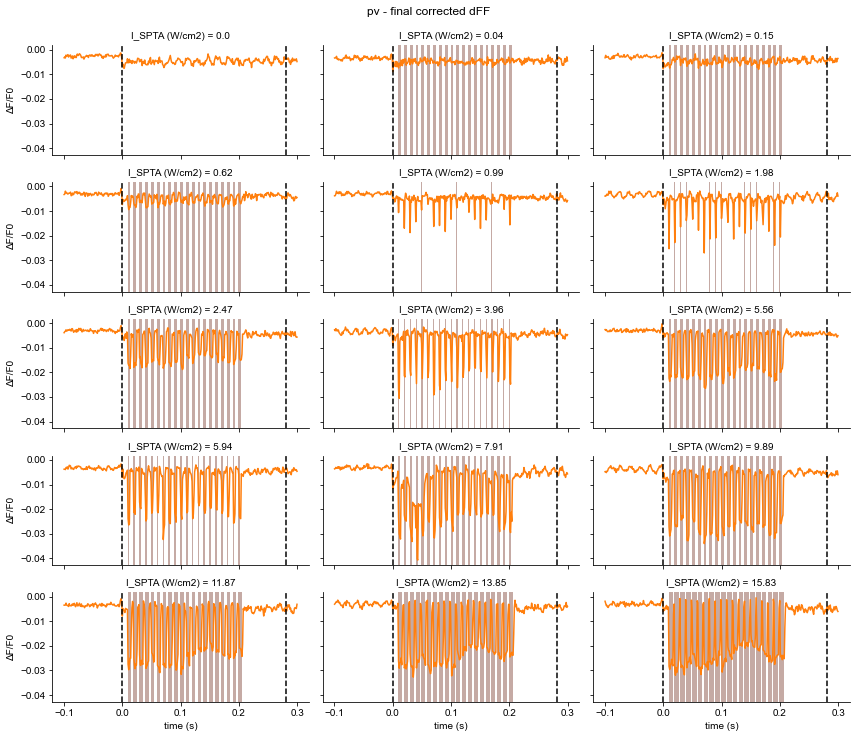

In [13]:
# Plot corrected signal around stimulus
title = f'{mouseline} - final corrected dFF'
figs[title] = plot_rowagg_profiles(
    aggregate_across_datasets(trialagg_dFF),
    ykey=input_ykey,
    tbounds=tbounds['zoomed'],
    color=refcolor,
    **pltkwargs
)
figs[title].suptitle(title, y=1.02)

### Inspect "within-pulse" trends

 2025/07/09 14:19:15: computing pulse index and relative time w.r.t pulse onset
 2025/07/09 14:19:15: max-rectifying pulse profiles
 2025/07/09 14:19:16: computing cross-dataset aggregates


Text(0.5, 1.02, 'pv - single pulse dFF')

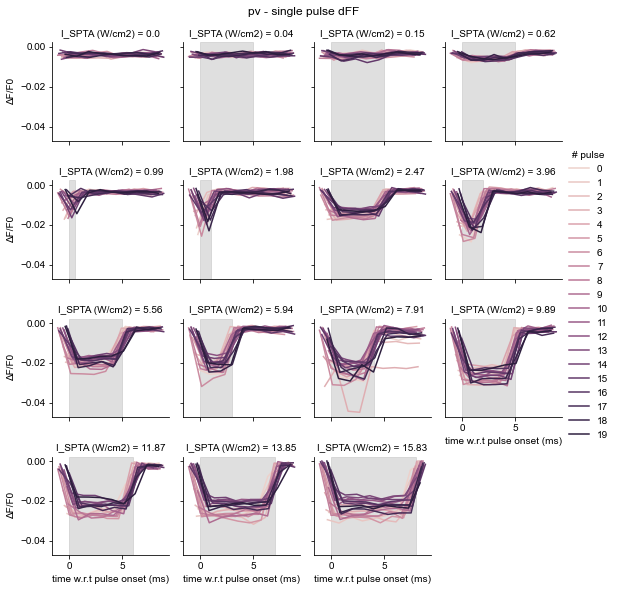

In [ ]:
# Extract profile during stim window
stim_tbounds = np.array([STIM_TRIG_DELAY, STIM_TRIG_DELAY + dur])
stim_ibounds = np.ceil(stim_tbounds * fps * lpf).astype(int) + fidx.iref
stim_trialagg_dFF = trialagg_dFF.loc[pd.IndexSlice[:, :, stim_ibounds[0]:stim_ibounds[1] - 1], :].copy()

# Compute pulse index and relative time w.r.t pulse onset
logger.info('computing pulse index and relative time w.r.t pulse onset')
tvec = stim_trialagg_dFF[Label.TIME].values - stim_tbounds[0]
stim_trialagg_dFF[Label.IPULSE] = (tvec // (1 / PRF)).astype(int)
stim_trialagg_dFF[Label.PULSERELTIME] = ((tvec % (1 / PRF)) - 1 / (fps * lpf)) * 1e3  # convert to time in ms

# Max-rectify within-pulse profiles
logger.info('max-rectifying pulse profiles')
stim_trialagg_dFF[input_ykey] = (stim_trialagg_dFF
    .groupby([Label.DATASET, Label.RUN, Label.IPULSE])
    [input_ykey]
    .transform(lambda y: y - y.max())
)

# Plot "single pulse" dFF profiles
g = sns.relplot(
    kind='line',
    data=aggregate_across_datasets(stim_trialagg_dFF),
    x=Label.PULSERELTIME,
    y=input_ykey,
    hue=Label.IPULSE,
    col=group_key,
    col_wrap=4,
    height=2,
    legend='full',
)
g.set_axis_labels(Label.PULSERELTIME, Label.DFF)

# Add shaded areas for pulses
for colval, ax in g.axes_dict.items():
    DC = col_DC_map.loc[colval]
    if DC > 0:
        PD = (DC * 1e-2) / PRF * 1e3  # ms
        tpulse = np.array([0, PD])
        ax.axvspan(*tpulse, color='silver', alpha=0.5)  # shaded area for pulse duration

title = f'{mouseline} - single pulse dFF'
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Quantify pulse-evoked dFF dip and its dependence on parameters and pulse index

 2025/07/09 14:19:21: computing pulse-evoked dFF dip
 2025/07/09 14:19:21: extracting "noise dip" for reference condition
 2025/07/09 14:19:21: plotting average pulse-evoked dFF dip vs P, ISPPA and DC
 2025/07/09 14:19:21: computing relative dip per pulse w.r.t first one
 2025/07/09 14:19:21: plotting relative change in pulse-evoked dFF dip


Text(0.5, 1.02, 'pv - relative change in pulse-evoked dFF dip')

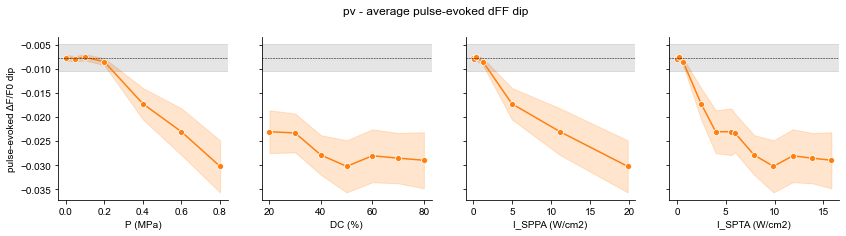

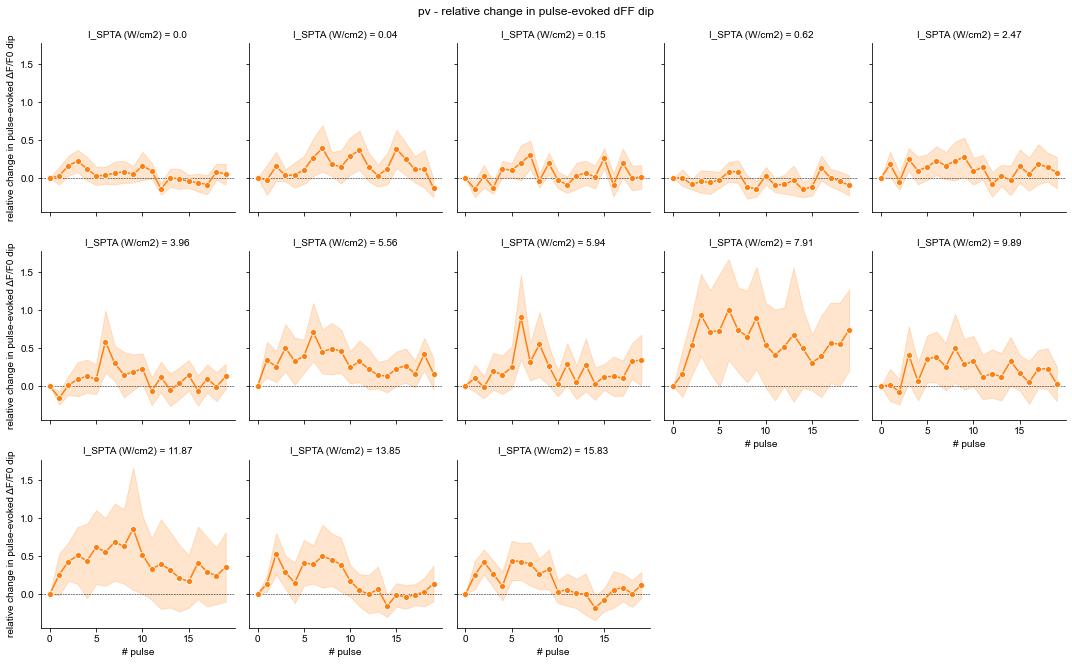

In [ ]:
# Compute pulse-evoked dFF dip, along with P, DC, ISPPA, and grouping variable
logger.info('computing pulse-evoked dFF dip')
dip_ykey = f'pulse-evoked {Label.DFF} dip'
pulse_stats = (
    stim_trialagg_dFF
    .groupby([Label.DATASET, Label.RUN, Label.IPULSE])
    .agg({
        input_ykey: lambda x: -np.ptp(x),
        **{k: 'first' for k in exp_keys},
    })
    .rename(columns={input_ykey: dip_ykey})
)

# Extract "noise dip" for reference condition
logger.info('extracting "noise dip" for reference condition')
noisedip = pulse_stats[pulse_stats[group_key] == group_refval][dip_ykey]

# For main analysis, restrict to DC >= 20% to avoid sub-sampled dips at low DCs
if group_key == Label.ISPTA:
    pulse_stats = pulse_stats[pulse_stats[Label.DC] >= 20.]

# Average across pulses for each column grouping value and dataset
aggfuncs = {k: 'mean' if k == dip_ykey else 'first' for k in pulse_stats.columns}
pulseavg_stats = (
    pulse_stats
    .groupby([Label.DATASET, Label.RUN])
    .agg(aggfuncs)
)

# Plot average pulse-evoked dip vs P, ISPPA and DC
logger.info('plotting average pulse-evoked dFF dip vs P, ISPPA and DC')
title = f'{mouseline} - average pulse-evoked dFF dip'
xkeys = exp_keys if group_key == Label.ISPTA else [group_key]
figs[title], axes = plt.subplots(1, len(xkeys), figsize=(3.5 * len(xkeys), 3), sharey=True)
axes = np.atleast_1d(axes)  # Ensure axes is always an array
figs[title].suptitle(title, y=1.02)
for ax, xkey in zip(axes, xkeys):
    if xkey == Label.DC:
        pltdata = pulseavg_stats[pulseavg_stats[Label.P] == P_REF] 
    elif xkey in (Label.P, Label.ISPPA):
        pltdata = pulseavg_stats[pulseavg_stats[Label.DC] == DC_REF]
    else:
        pltdata = pulseavg_stats.copy()
    for kwargs in [
            # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
            dict(marker='o', errorbar='se')
        ]:
        sns.lineplot(
            ax=ax,
            data=pltdata,
            x=xkey,
            y=dip_ykey,
            color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
            legend=ax is axes[-1],
            **kwargs,
        )
    sns.despine(ax=ax)
    ax.axhline(noisedip.mean(), color='k', linestyle='--', linewidth=0.5, label='noise dip')
    ax.axhspan(noisedip.mean() - noisedip.std(), noisedip.mean() + noisedip.std(), color='k', alpha=0.1)

# Compute relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('computing relative dip per pulse w.r.t first one')
rel_dip_ykey = f'relative change in {dip_ykey}'
refdips = pulse_stats.loc[pd.IndexSlice[:, :, 0], dip_ykey].droplevel(Label.IPULSE)
pulse_stats[rel_dip_ykey] = (pulse_stats[dip_ykey] - refdips) / refdips

# Plot relative dip per pulse w.r.t first one, for each grouping variable and dataset
logger.info('plotting relative change in pulse-evoked dFF dip')
title = f'{mouseline} - relative change in pulse-evoked dFF dip'
g = sns.FacetGrid(
    data=pulse_stats.reset_index(),
    col=group_key,
    col_wrap=5,
    height=3,
)
for ax in g.axes_dict.values():
    ax.axhline(0, color='k', linestyle='--', linewidth=0.5)
for kwargs in [
        # dict(units=Label.DATASET, estimator=None, alpha=0.5), 
        dict(marker='o', errorbar='se')
    ]:
    g.map_dataframe(
        sns.lineplot,
        x=Label.IPULSE,
        y=rel_dip_ykey,
        color=refcolor if 'units' not in kwargs else desaturate_color(refcolor),
        **kwargs
    )
figs[title] = g.figure
figs[title].suptitle(title, y=1.02)

### Save figures

In [16]:
figs = {k: v for k, v in figs.items() if v is not None}
save_figs_book(figsdir, figs, suffix=f'intraframe_{mouseline}_{analysis_type}_analysis')

 2025/07/09 14:19:24: saving figures in /Users/tlemaire/Documents/data/usnm/figs/2025.07.09/figs_intraframe_pv_main_analysis.pdf:


100%|██████████| 14/14 [00:17<00:00,  1.24s/it]


### Notify upon completion

In [17]:
# Get time stamp from notebook completion
tstamp_end = datetime.datetime.now()

# Log completion process
s = f'intra-pulse analysis notebook completed in {tstamp_end - tstamp_start} s'
if slack_notify:
    jupyter_slack.notify_self(s)
logger.info(s)

 2025/07/09 14:19:42: intra-pulse analysis notebook completed in 0:02:10.463202 s
